# Midterm Project


You will demonstrate your ability to solve a classification task.

The notebook that you submit *should follow the Recipe for Machine Learning* in addition to answering the questions.

# Objectives

For the student to demonstrate mastery on solving a classification problem and presenting
the entire Recipe for Machine Learning process in a notebook.

There will be little explicit direction for this task.

It is meant to be analagous to a pre-interview task that a potential employer might assign
to verify your skill

# The problem

You are to predict whether a company will go bankrupt in the following year, based on financial attributes of the company.
- Each row of data corresponds to a single company
- There are 64 attributes, described in the section below
- The last column (`Bankrupt`) is 1 if the company subsequently went bankrupt; 0 if it did not go bankrupt
- The first column is a Company Identifier

# The Data

Here's the code to get the data.

In [1]:
import pandas as pd
import numpy as np
import os

# Note the use of *relative path*; your assignments should all use relative rather than absolute paths
DATA_PATH = "./data/midterm_project"

data = pd.read_csv( os.path.join(DATA_PATH, "bankruptcy_data.csv") )


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

from sklearn import linear_model, preprocessing, model_selection 
from sklearn.pipeline import Pipeline
try:
    from sklearn.impute import SimpleImputer # Scikit-Learn 0.20+
except ImportError:
    from sklearn.preprocessing import Imputer as SimpleImputer

from sklearn.preprocessing import OneHotEncoder 
from sklearn.pipeline import FeatureUnion
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

## Description of attributes

At first glance, all the variables are accounting features about sales, profits, liability, inventory. They represents the operations of companies but must have many things in common.

# Split and Check

In [3]:
train_data, test_data = train_test_split(data, test_size=0.20, random_state=21)
train_data.head()

,Id,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X56,X57,X58,X59,X60,X61,X62,X63,X64,Bankrupt
3563,1996,-0.13035,1.1514,4.5E-05,1.0034,-14.603,-0.10454,-0.13035,-0.13151,0.14841,...,-0.384950,0.86085,1.87690,-7.5163,34.577,23.331,32.618,11.19,0.15041,0
2842,3749,0.11673,0.67658,0.24282,1.6423,24.563,0.11652,0.13781,0.26315,1.1517,...,0.131720,0.65561,0.86828,1.6767,6.7476,2.6428,117.360,3.1101,3.1012,0
2864,2371,0.098993,0.32834,0.16203,1.5173,28.92,0,0.098993,2.0457,1.4904,...,0.054936,0.14739,0.93469,0,32.29,4.7094,76.712,4.758,2.8405,0
590,3352,-0.061918,0.17774,0.22465,3.7606,112.15,0,-0.061918,4.6262,0.77036,...,0.219790,-0.075302,0.79795,0.098332,22.47,18.012,38.557,9.4666,1.1101,0
451,4011,0.014635,0.59418,0.026616,1.0899,-21.245,-0.00852,0.01565,0.68298,1.4629,...,-0.039986,0.036064,0.99142,0.4103,13.184,6.9791,73.893,4.9396,2.1602,0


Notice that there are zeros but they should be fine. For example, for X6, it might because that the retain earnings of a company equals zero

In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3260 entries, 3563 to 3017
Data columns (total 66 columns):
Id          3260 non-null int64
X1          3260 non-null object
X2          3260 non-null object
X3          3260 non-null object
X4          3260 non-null object
X5          3260 non-null object
X6          3260 non-null object
X7          3260 non-null object
X8          3260 non-null object
X9          3260 non-null object
X10         3260 non-null object
X11         3260 non-null object
X12         3260 non-null object
X13         3260 non-null float64
X14         3260 non-null object
X15         3260 non-null object
X16         3260 non-null object
X17         3260 non-null object
X18         3260 non-null object
X19         3260 non-null float64
X20         3260 non-null float64
X21         3260 non-null object
X22         3260 non-null object
X23         3260 non-null float64
X24         3260 non-null object
X25         3260 non-null object
X26         3260 non-null obj

- It looks like there is no missing values from number of elements but we could found that some values are represented as "?" , which are missing
- They all look like numeric variables from data description but 49 of them are objects so I check the type. It is string and we need to convert them to float.

In [5]:
type(train_data["X2"][1])

str

# Transform Missing Values
- convert all of ? to Numpy NaN for convenience

In [6]:
# Count of all the missing values
print("Number of ? in training data set: ")
for i in train_data:
    if isinstance(train_data[i][48], str) :
        print(i, end = ': ') 
        print(train_data[i].value_counts()["?"])

Number of ? in training data set: 
X1: 4
X2: 4
X3: 4
X4: 14
X5: 4
X6: 4
X7: 4
X8: 13
X9: 1
X10: 4
X11: 4
X12: 14
X14: 4
X15: 6
X16: 13
X17: 13
X18: 4
X21: 78
X22: 4
X24: 69
X25: 4
X26: 13
X27: 251
X28: 52
X29: 4
X32: 22
X33: 14
X34: 13
X35: 4
X36: 4
X37: 1429
X38: 4
X40: 14
X41: 38
X45: 159
X46: 14
X47: 18
X48: 4
X50: 13
X51: 4
X52: 18
X53: 52
X54: 52
X57: 2
X59: 2
X60: 159
X61: 7
X63: 14
X64: 52


- X37 has nealy one half of missing values, so I would not use it in my model. Others should be fine.
- To process the missing data easier, I replace all the ? with NaN

In [7]:
train_data = train_data.drop("X37", axis=1)
test_data = test_data.drop("X37", axis=1)

In [8]:
for i in train_data : 
    train_data[i].replace("?",np.nan, inplace=True)
    # do the same thing to test data
    test_data[i].replace("?",np.nan, inplace=True)

ID seems useless, so I delete it from our data set

In [9]:
# delete ID
train_data.drop("Id", axis=1, inplace = True)
test_data.drop("Id", axis=1, inplace = True)

In [10]:
train_data.tail(8)

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X56,X57,X58,X59,X60,X61,X62,X63,X64,Bankrupt
3491,0.049678,0.19009,0.39398,3.3997,23.823,0.1155,0.065111,3.3198,1.0918,0.63107,...,0.084087,0.07872,0.915910,0.041066,3.9769,21.638,64.376,5.6698,2.1068,0
1144,0.028708,0.51227,-0.061343,0.78135,-86.461,0,0.029788,0.95209,0.82866,0.48773,...,0.077404,0.05886,0.967100,0.32811,7.7762,10.439,123.570,2.9537,1.0613,0
2416,0.046422,0,0.2462,NaN,3180.9,0,0.046422,NaN,0.010473,1,...,-1.283300,0.046422,0.340160,0,0.3,0.13339,0.000,NaN,0.013894,0
48,0.14194,0.19154,0.49417,3.6486,107.29,0,0.17871,4.2208,1.5823,0.80846,...,0.110940,0.17557,0.888140,0,31.083,4.1031,43.040,8.4804,4.9561,0
772,0.23823,0.2714,0.18006,1.8572,-18.11,0.55657,0.23823,2.5494,1.0899,0.6919,...,0.082522,0.34431,0.917480,0.088675,9.286,37.485,27.760,13.149,4.5284,0
1848,0.003991,0.7114,0.12448,1.175,17.789,-0.013219,0.003991,0.40569,3.4803,0.2886,...,0.999390,0.01383,0.001669,0,13.722,6.6614,74.608,4.8922,21.205,0
1231,0.035388,0.52591,0.20886,1.5289,-42.453,0.1551,0.047951,0.88992,1.0529,0.46802,...,0.050228,0.075613,0.949770,0.27993,3.4399,4.1564,128.500,2.8405,2.8308,0
3017,-0.013118,1.2144,-0.20539,0.82064,-79.495,-0.21783,-0.000674,-0.17657,2.3353,-0.21443,...,0.078027,0.061177,1.000200,-0.19702,9.039,3.9025,178.990,2.0393,38.772,0


In [11]:
# Convert all the columns of string to float and convert bankrupt back to int
train_data = train_data.astype(float)
train_data['Bankrupt'] = train_data['Bankrupt'].astype(int)

# to test data
test_data = test_data.astype(float)
test_data['Bankrupt'] = test_data['Bankrupt'].astype(int)

train_data.tail(7)

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X56,X57,X58,X59,X60,X61,X62,X63,X64,Bankrupt
1144,0.028708,0.51227,-0.061343,0.78135,-86.461,0.000000,0.029788,0.95209,0.828660,0.48773,...,0.077404,0.058860,0.967100,0.328110,7.7762,10.43900,123.570,2.9537,1.061300,0
2416,0.046422,0.00000,0.246200,NaN,3180.900,0.000000,0.046422,NaN,0.010473,1.00000,...,-1.283300,0.046422,0.340160,0.000000,0.3000,0.13339,0.000,NaN,0.013894,0
48,0.141940,0.19154,0.494170,3.64860,107.290,0.000000,0.178710,4.22080,1.582300,0.80846,...,0.110940,0.175570,0.888140,0.000000,31.0830,4.10310,43.040,8.4804,4.956100,0
772,0.238230,0.27140,0.180060,1.85720,-18.110,0.556570,0.238230,2.54940,1.089900,0.69190,...,0.082522,0.344310,0.917480,0.088675,9.2860,37.48500,27.760,13.1490,4.528400,0
1848,0.003991,0.71140,0.124480,1.17500,17.789,-0.013219,0.003991,0.40569,3.480300,0.28860,...,0.999390,0.013830,0.001669,0.000000,13.7220,6.66140,74.608,4.8922,21.205000,0
1231,0.035388,0.52591,0.208860,1.52890,-42.453,0.155100,0.047951,0.88992,1.052900,0.46802,...,0.050228,0.075613,0.949770,0.279930,3.4399,4.15640,128.500,2.8405,2.830800,0
3017,-0.013118,1.21440,-0.205390,0.82064,-79.495,-0.217830,-0.000674,-0.17657,2.335300,-0.21443,...,0.078027,0.061177,1.000200,-0.197020,9.0390,3.90250,178.990,2.0393,38.772000,0


In [12]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3260 entries, 3563 to 3017
Data columns (total 64 columns):
X1          3256 non-null float64
X2          3256 non-null float64
X3          3256 non-null float64
X4          3246 non-null float64
X5          3256 non-null float64
X6          3256 non-null float64
X7          3256 non-null float64
X8          3247 non-null float64
X9          3259 non-null float64
X10         3256 non-null float64
X11         3256 non-null float64
X12         3246 non-null float64
X13         3260 non-null float64
X14         3256 non-null float64
X15         3254 non-null float64
X16         3247 non-null float64
X17         3247 non-null float64
X18         3256 non-null float64
X19         3260 non-null float64
X20         3260 non-null float64
X21         3182 non-null float64
X22         3256 non-null float64
X23         3260 non-null float64
X24         3191 non-null float64
X25         3256 non-null float64
X26         3247 non-null float64
X27   

Now, they are all numeric values and counts exclude missing values

# Exploratory Data Analysis

In [13]:
print("Total number of current variables: {}".format(len(train_data.columns)))
print(train_data.columns)
train_data.describe()

Total number of current variables: 64
Index(['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11',
       'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20', 'X21',
       'X22', 'X23', 'X24', 'X25', 'X26', 'X27', 'X28', 'X29', 'X30', 'X31',
       'X32', 'X33', 'X34', 'X35', 'X36', 'X38', 'X39', 'X40', 'X41', 'X42',
       'X43', 'X44', 'X45', 'X46', 'X47', 'X48', 'X49', 'X50', 'X51', 'X52',
       'X53', 'X54', 'X55', 'X56', 'X57', 'X58', 'X59', 'X60', 'X61', 'X62',
       'X63', 'X64', 'Bankrupt'],
      dtype='object')


,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X56,X57,X58,X59,X60,X61,X62,X63,X64,Bankrupt
count,3256.000000,3256.000000,3256.000000,3246.000000,3.256000e+03,3256.000000,3256.000000,3247.000000,3259.000000,3256.000000,...,3260.000000,3258.000000,3260.000000,3258.000000,3101.000000,3253.000000,3260.000000,3246.000000,3208.000000,3260.000000
mean,-0.127546,0.581185,0.151787,4.334740,-3.190811e+02,-0.216767,-0.114869,6.022402,1.611023,0.485390,...,0.046294,-0.422447,0.968272,0.173587,42.551993,10.697012,206.372918,8.129792,87.174377,0.102761
std,8.162658,1.706967,1.529775,28.444208,1.891398e+04,9.465068,8.163312,73.759309,1.660992,4.985557,...,0.903105,23.336944,1.052041,5.409574,288.014238,38.495799,2750.224324,33.948156,2852.112787,0.303693
min,-463.890000,0.000000,-72.067000,-0.403110,-1.076400e+06,-463.890000,-463.890000,-0.986570,0.000191,-71.444000,...,-46.788000,-1236.300000,-0.164390,-184.980000,-12.440000,-0.092493,-236.530000,-1.543200,-3.726500,0.000000
25%,0.002831,0.254515,0.035150,1.071550,-4.726175e+01,0.000000,0.003980,0.459560,1.014250,0.305988,...,0.010004,0.014753,0.873730,0.000000,5.191500,4.233900,45.687000,2.977625,2.196925,0.000000
50%,0.045273,0.454280,0.211815,1.624800,7.796150e-02,0.000000,0.055403,1.144300,1.145200,0.521810,...,0.053062,0.113275,0.950995,0.003903,8.732900,6.142400,76.212000,4.758000,4.041300,0.000000
75%,0.117308,0.674335,0.420995,2.950000,4.817975e+01,0.097370,0.136010,2.816200,1.797000,0.720390,...,0.127808,0.240450,0.991535,0.188860,16.923000,9.435300,122.120000,7.904900,9.500650,0.000000
max,2.352300,72.416000,17.631000,788.090000,3.066900e+04,203.150000,2.352300,2922.000000,37.807000,266.860000,...,1.000000,87.981000,47.788000,83.095000,7391.200000,1266.800000,127450.000000,1526.800000,158180.000000,1.000000


For many variables, the min and max are far from the mean, I will look at their distribution later

# Check Correlations Between all the Xs

- We have a lot of variables from the financial statements of the companies.
- Some of them must be highly correlated. For example, "X33 operating expenses / short-term liabilities" and "X34 operating expenses / total liabilities", the numerators are the same and denominators are similar.
- I'd better check correlations in detail

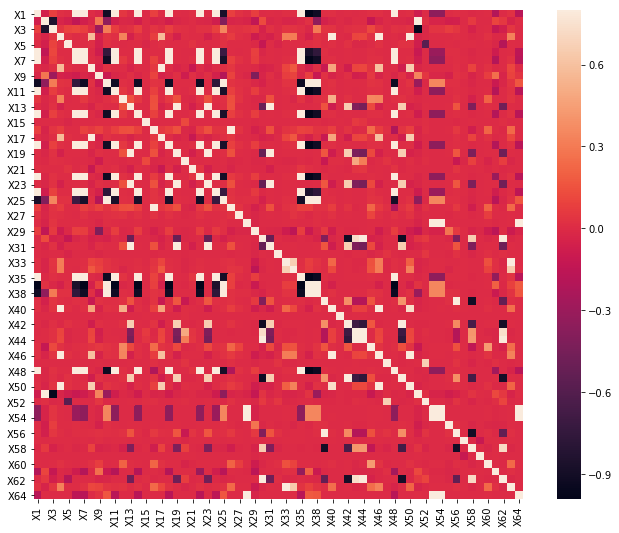

In [14]:
# Plotting Package inspired by TA's Recitation
import seaborn as sns
#correlation matrix
correlation = train_data.iloc[:,:len(train_data.columns)-1].corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(correlation, vmax=.8, square=True)

The heatmap tells correlations between all of our regressors, I find a lot of variables that are highly correlated, where the color is either dark black or pure white. 

I mutually select and delete them from our training data set to avoid duplicate information, the multicollinearity probelm.

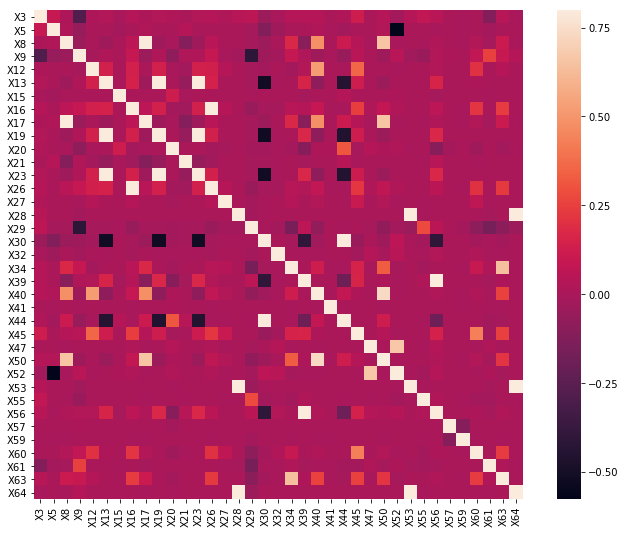

In [15]:
# columns to delete
cols = ['X1','X2','X4','X6','X7','X10','X11','X14','X18','X22','X24','X25','X31',
        'X33','X35','X36','X38','X42','X43','X46','X48','X49','X51','X54','X58','X62']
train = train_data.drop(cols, axis=1)
# do the same transformation to test set
test = test_data.drop(cols, axis=1)
correlation = train.iloc[:,:len(train.columns)-1].corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(correlation, vmax=.8, square=True)

# Map after cleaning

This is the heatmap after removing. Although the overall color tone becomes darker, the darkest point of the bar on the right decrease from 0.9 to 0.5.

I do want to keep variables as many as possible.

In [16]:
print("{} Xs remained".format(len(train.columns)-1))

37 Xs remained


# Explore Outliers
- Some of our variables have very large ourliers, others have very small one
- I will visualize the distribution first

In [17]:
train.describe()

,X3,X5,X8,X9,X12,X13,X15,X16,X17,X19,...,X53,X55,X56,X57,X59,X60,X61,X63,X64,Bankrupt
count,3256.000000,3.256000e+03,3247.000000,3259.000000,3246.000000,3260.000000,3.254000e+03,3247.000000,3247.000000,3260.000000,...,3208.000000,3.260000e+03,3260.000000,3258.000000,3258.000000,3101.000000,3253.000000,3246.000000,3208.000000,3260.000000
mean,0.151787,-3.190811e+02,6.022402,1.611023,0.761671,-0.079851,-8.168960e+02,0.771717,7.109557,-0.130559,...,12.872621,1.100539e+04,0.046294,-0.422447,0.173587,42.551993,10.697012,8.129792,87.174377,0.102761
std,1.529775,1.891398e+04,73.759309,1.660992,18.768224,6.841205,1.714462e+05,5.996490,73.760058,6.864122,...,412.096859,6.030299e+04,0.903105,23.336944,5.409574,288.014238,38.495799,33.948156,2852.112787,0.303693
min,-72.067000,-1.076400e+06,-0.986570,0.000191,-96.239000,-310.340000,-9.632400e+06,-52.440000,0.000000,-310.800000,...,-1088.700000,-2.955400e+05,-46.788000,-1236.300000,-184.980000,-12.440000,-0.092493,-1.543200,-3.726500,0.000000
25%,0.035150,-4.726175e+01,0.459560,1.014250,0.010072,0.021659,1.946275e+02,0.067578,1.481550,0.002582,...,0.734260,4.738900e+01,0.010004,0.014753,0.000000,5.191500,4.233900,2.977625,2.196925,0.000000
50%,0.211815,7.796150e-02,1.144300,1.145200,0.156460,0.066074,8.306900e+02,0.228240,2.195800,0.034022,...,1.277300,1.746700e+03,0.053062,0.113275,0.003903,8.732900,6.142400,4.758000,4.041300,0.000000
75%,0.420995,4.817975e+01,2.816200,1.797000,0.539710,0.134928,2.190225e+03,0.641860,3.906800,0.087725,...,2.269475,8.111975e+03,0.127808,0.240450,0.188860,16.923000,9.435300,7.904900,9.500650,0.000000
max,17.631000,3.066900e+04,2922.000000,37.807000,1050.500000,78.190000,1.205600e+06,217.330000,2923.000000,77.244000,...,21702.000000,1.634200e+06,1.000000,87.981000,83.095000,7391.200000,1266.800000,1526.800000,158180.000000,1.000000


**Density Plots**

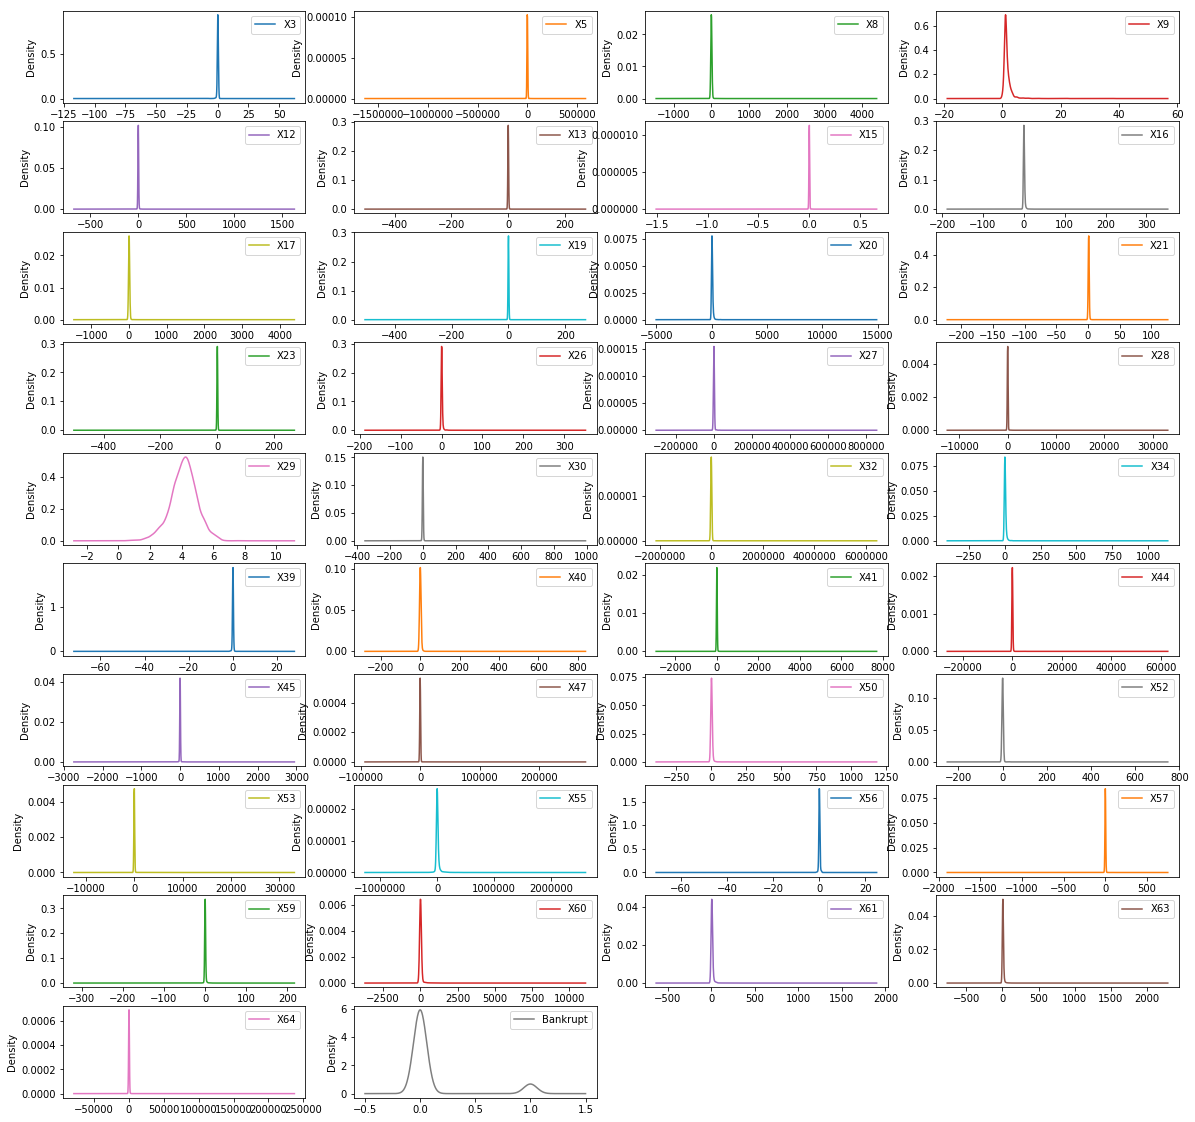

In [18]:
names = train.columns
train[names].plot(kind='density', subplots=True, layout = (10,4),sharex=False, sharey=False, figsize=(20,20))
plt.show()

- Look at the density graphs, most of our regressors values are concentrated around zero with a few outliers.
- To have a closer look at the outliers, I draw box plots

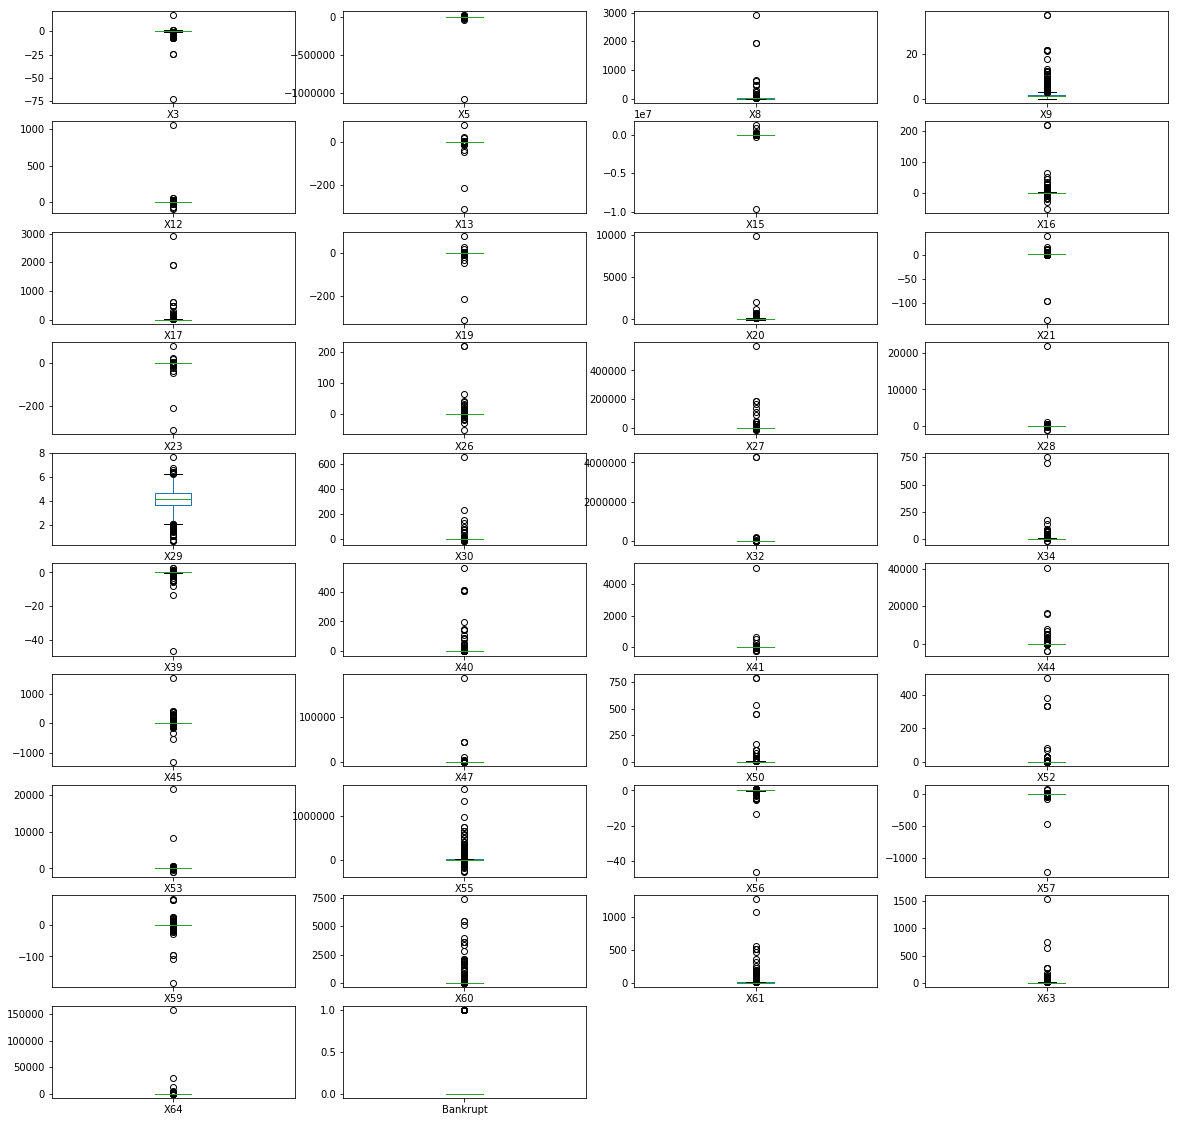

In [19]:
names = train.columns
train[names].plot(kind='box', subplots=True, layout = (10,4),sharex=False, sharey=False, figsize=(20,20))
plt.show()

# Scaling: Standardization

Instead of removing outliers (they may contain important information), I choose to standardize the data set to decrease the scale of outliers, by minusing the mean of training set and dividing by standard deviation

In [20]:
y = train["Bankrupt"]
x = train[train.columns[:-1]]
mean = x.mean()
std = x.std()
x_norm = (x - mean) / std
train_norm = x_norm
train_norm["Bankrupt"] = y

test_y = test["Bankrupt"]
test_x = test[test.columns[:-1]]
test_x_norm = (test_x - mean) / std
test_norm = test_x_norm
test_norm["Bankrupt"] = test_y

train_norm.head()

,X3,X5,X8,X9,X12,X13,X15,X16,X17,X19,...,X53,X55,X56,X57,X59,X60,X61,X63,X64,Bankrupt
3563,-0.099193,0.016098,-0.083432,-0.880566,-0.564266,-0.070109,-0.024758,-0.140721,-0.084613,-0.108939,...,-0.031609,-0.182501,-0.477513,0.054990,-1.421533,-0.027690,0.328191,0.090144,-0.030512,0
2842,0.059507,0.018169,-0.078082,-0.276535,-0.021161,0.031549,0.013774,-0.089287,-0.076350,0.036096,...,-0.030097,-0.081298,0.094591,0.046195,0.277862,-0.124315,-0.209223,-0.147863,-0.029478,0
2864,0.006695,0.018399,-0.053915,-0.072621,-0.023745,0.024296,0.010195,-0.063318,-0.055096,0.028697,...,-0.028131,-0.144966,0.009569,0.024418,-0.032089,-0.035630,-0.155539,-0.099322,-0.029569,0
590,0.047630,0.022800,-0.018929,-0.506121,-0.081124,0.000353,-0.001578,-0.184666,-0.020111,0.007311,...,-0.028362,-0.172472,0.192110,0.014875,-0.013911,-0.069726,0.190020,0.039378,-0.030176,0
451,-0.081823,0.015747,-0.072390,-0.089177,-0.037768,0.021075,0.018207,-0.102283,-0.073570,0.020579,...,-0.029783,-0.179273,-0.095538,0.019647,0.043758,-0.101967,-0.096580,-0.093972,-0.029807,0


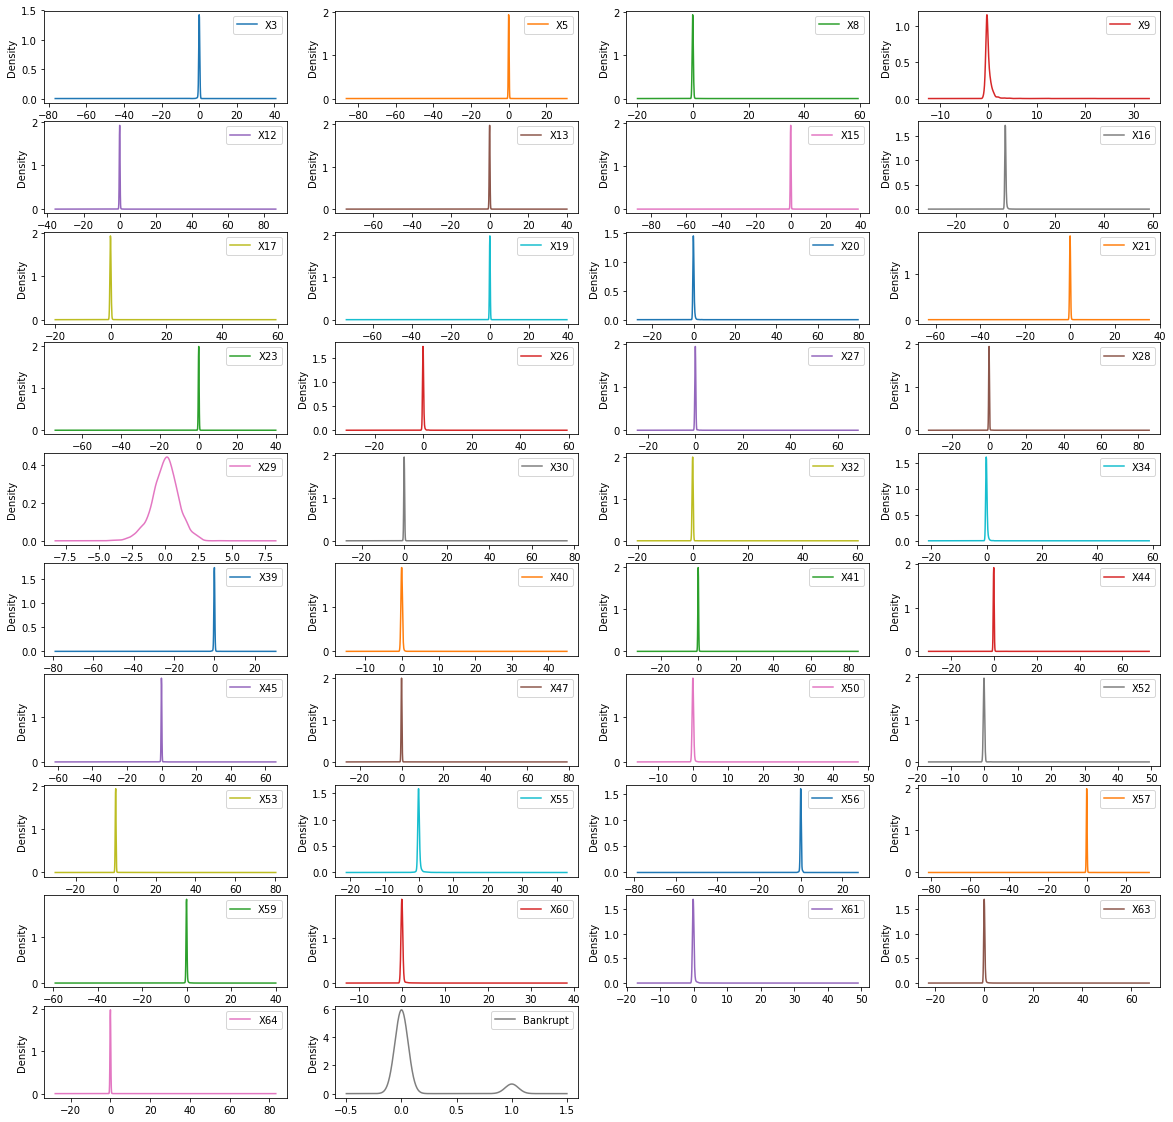

In [21]:
train_norm.plot(kind='density', subplots=True, layout = (10,4),sharex=False, sharey=False, figsize=(20,20))
plt.show()

# Fill Missing Value with Median and Graph KernalDensity

In [22]:
for i in train:
    train[i].replace(np.nan,train[i].median(), inplace=True)

from sklearn.neighbors import KernelDensity

def kde_plot(train, col_name):
    
    train_b = train[train['Bankrupt'] == 1][col_name].values.reshape(-1, 1)
    train_not_b = train[train['Bankrupt'] == 0][col_name].values.reshape(-1, 1)
    
    x_plot = np.linspace(train[col_name].min(), train[col_name].max(), 5000)[:, np.newaxis]
    
    fig, ax = plt.subplots(figsize=(20,3))
    
    kde_b = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(train_b)
    log_dens_b = kde_b.score_samples(x_plot)
    plt.plot(x_plot[:, 0], np.exp(log_dens_b), 'r-',label='Bankrupt')
    
    kde_not_b = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(train_not_b)
    log_dens_not_b = kde_not_b.score_samples(x_plot)
    plt.plot(x_plot[:, 0], np.exp(log_dens_not_b), 'y-',label='not Bankrupt')
    ax.set_title(col_name)
    plt.legend()
    plt.show()

Visualize how our variables separate bankrupt/ not

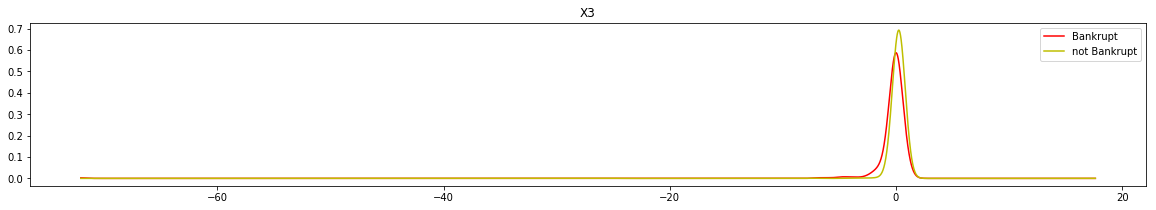

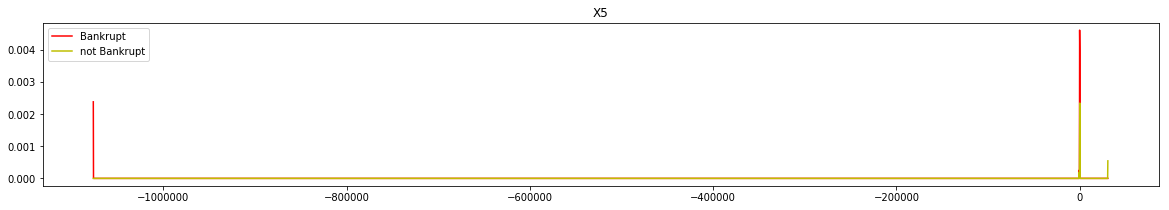

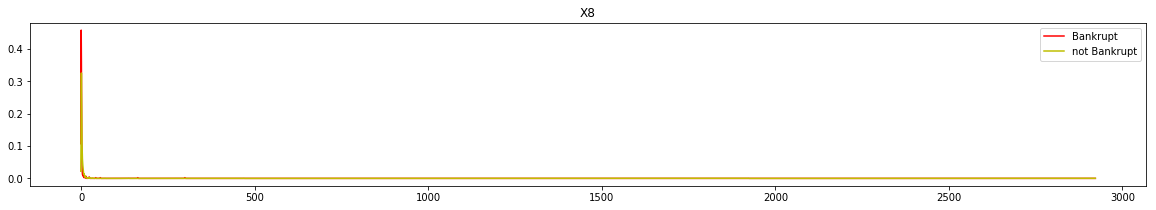

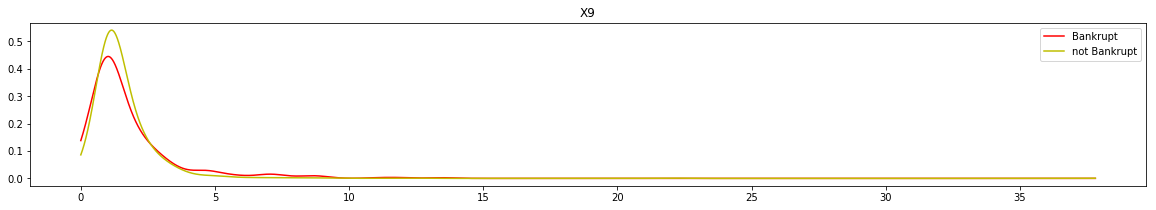

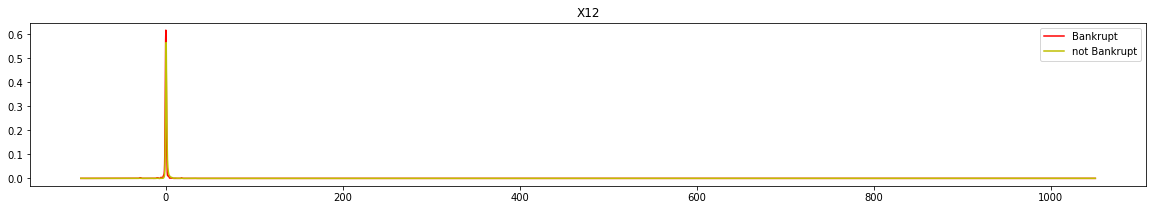

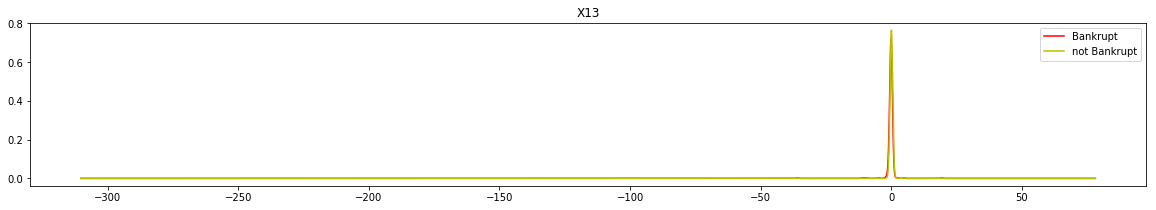

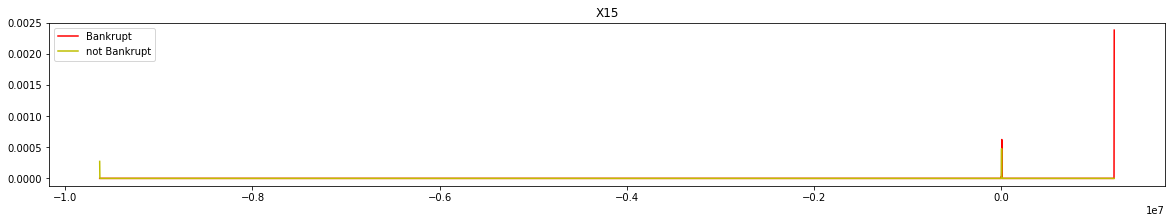

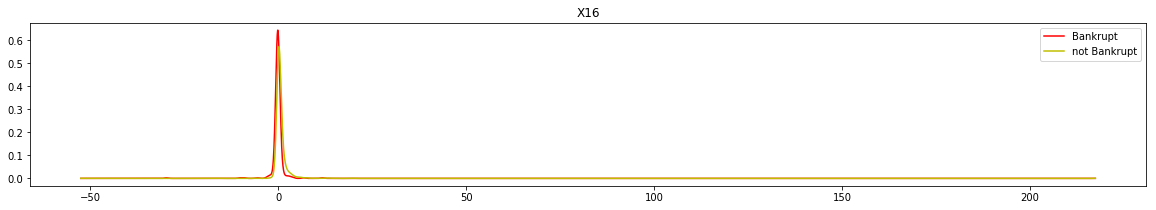

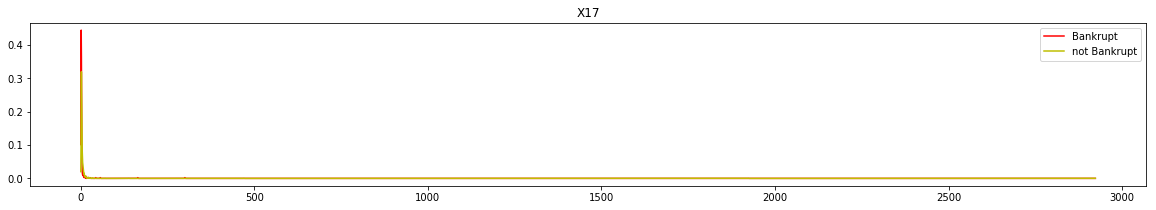

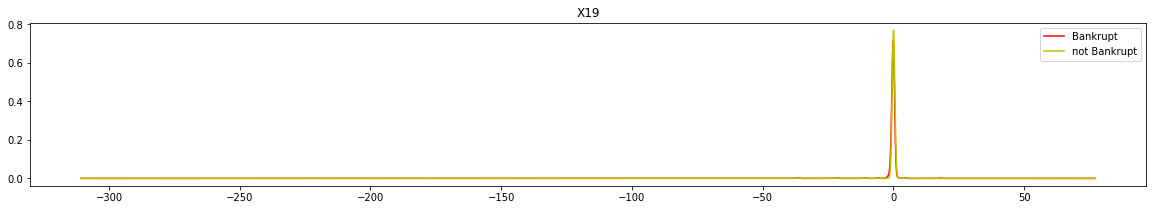

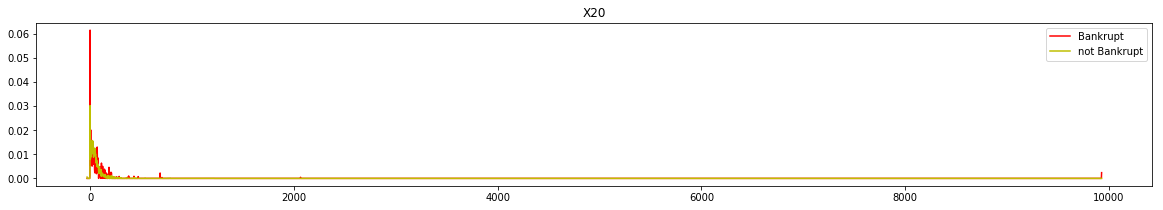

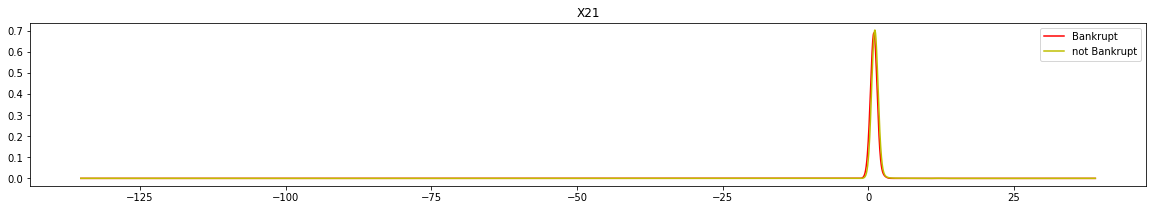

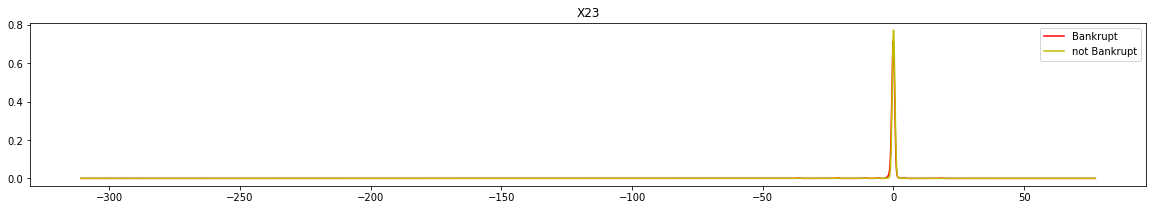

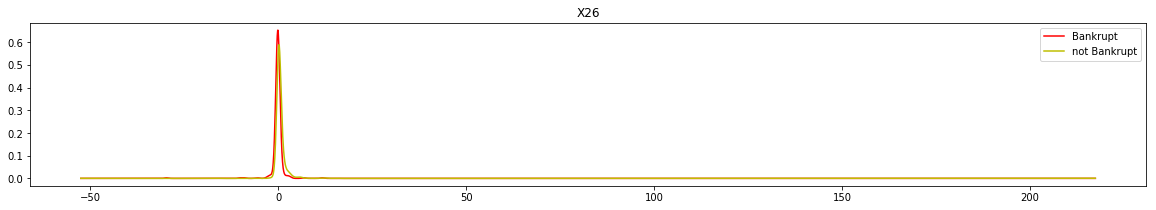

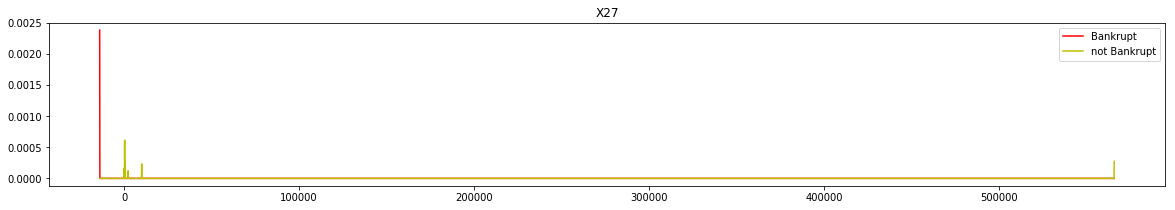

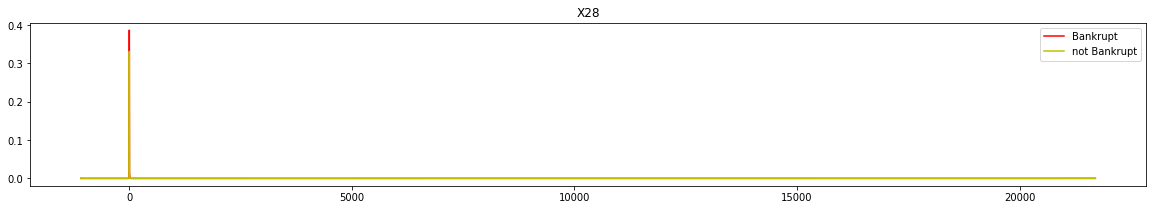

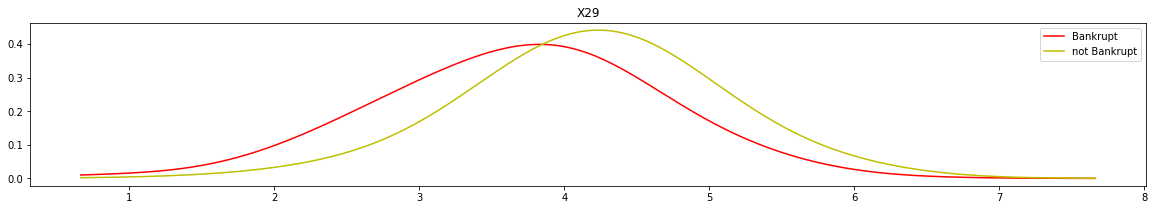

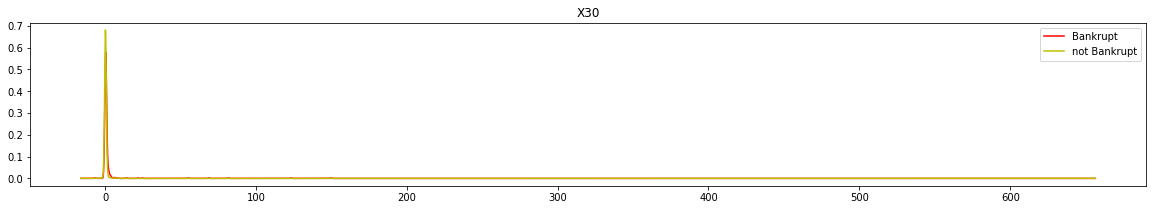

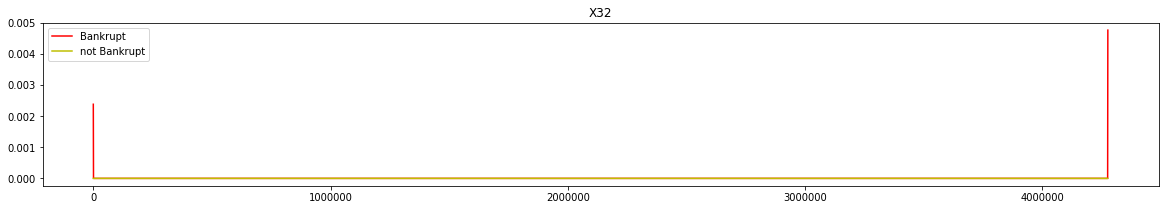

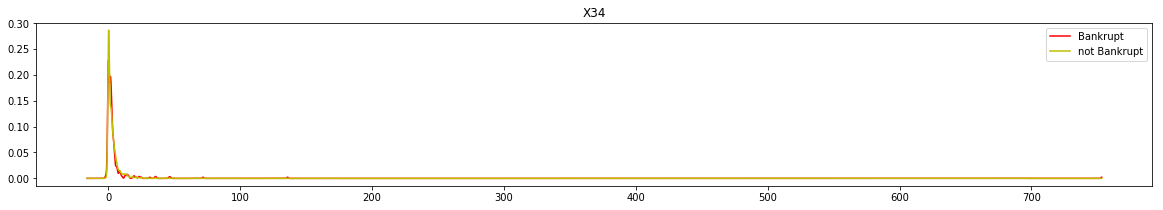

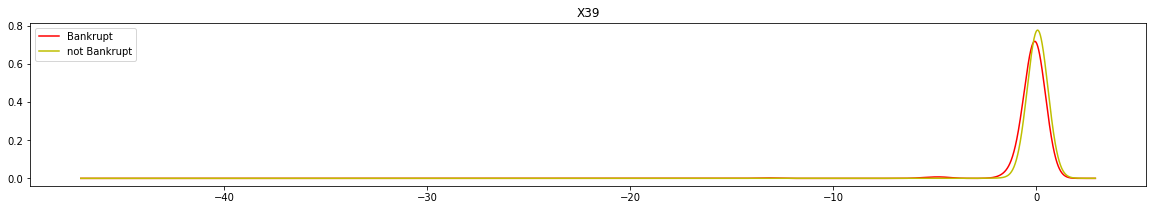

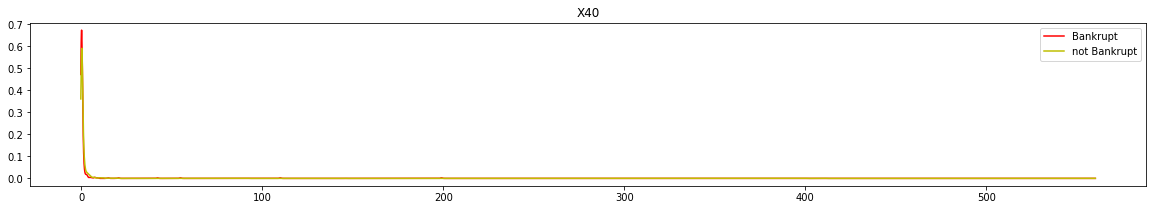

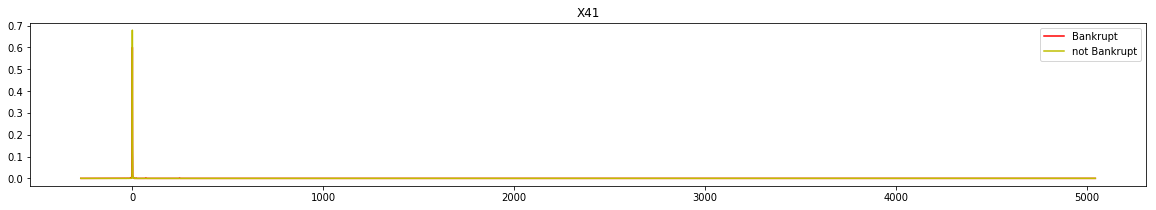

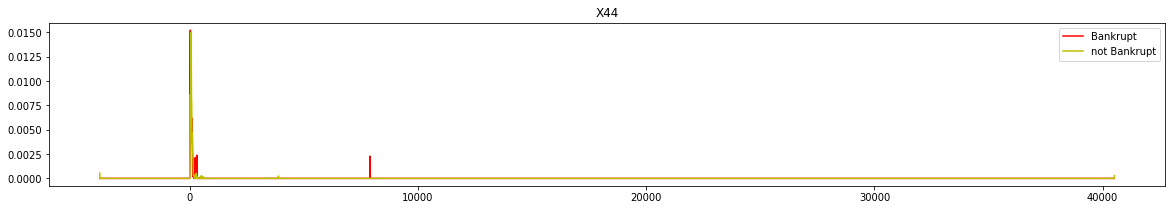

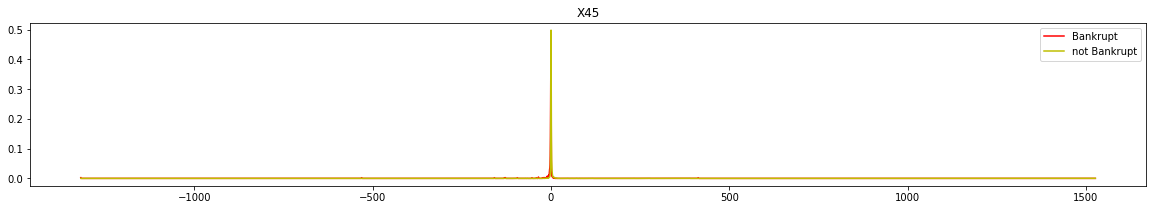

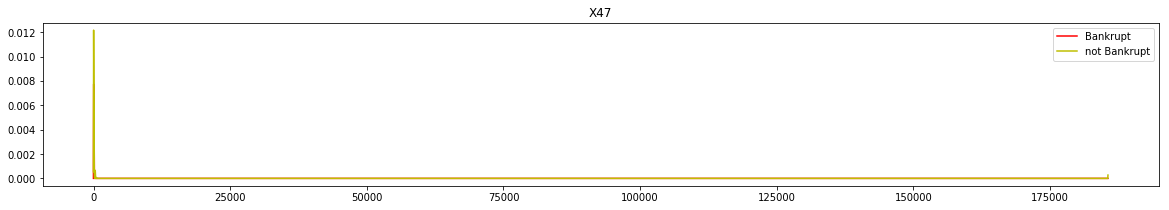

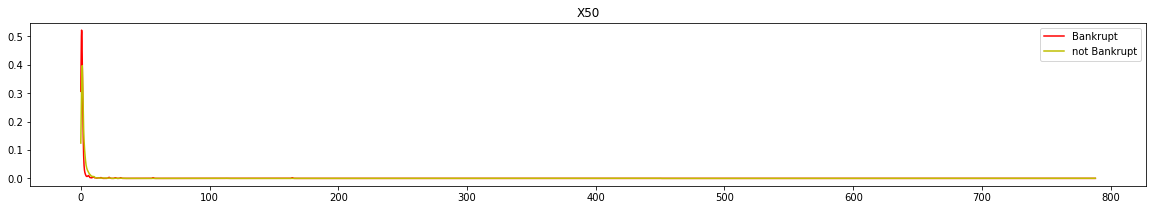

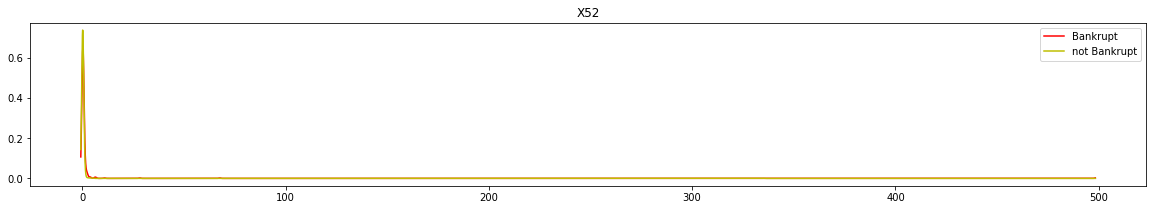

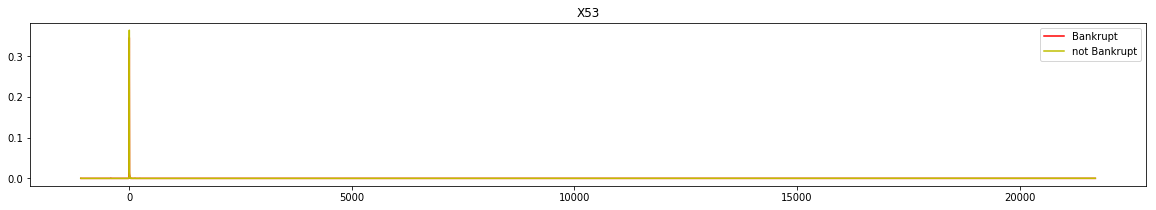

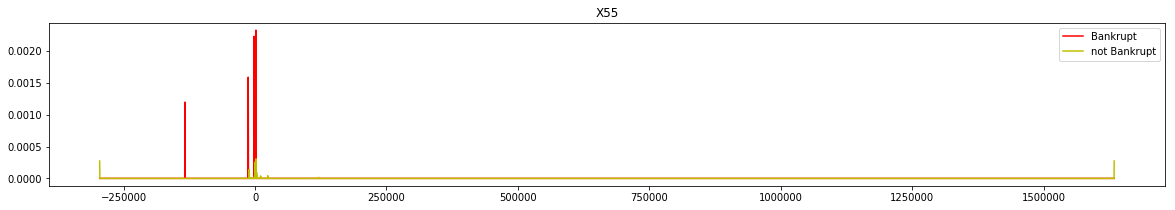

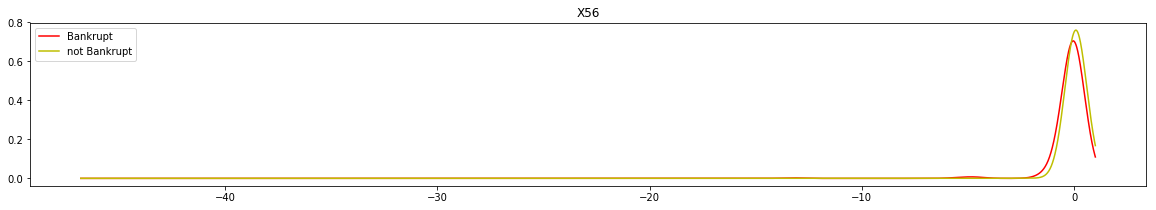

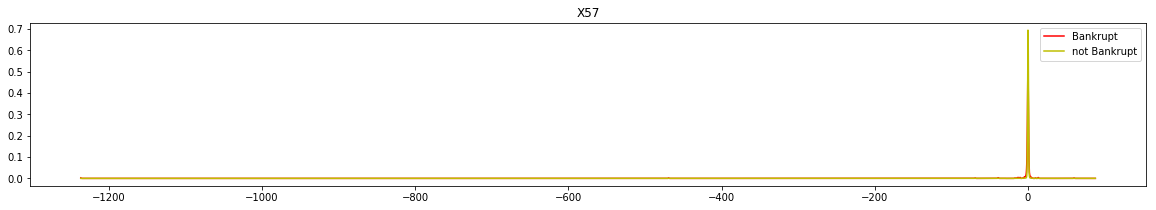

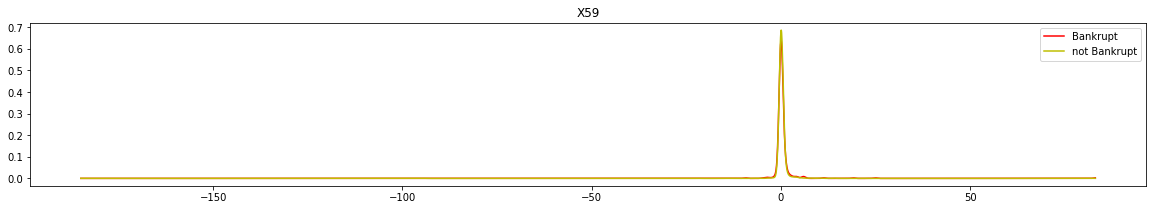

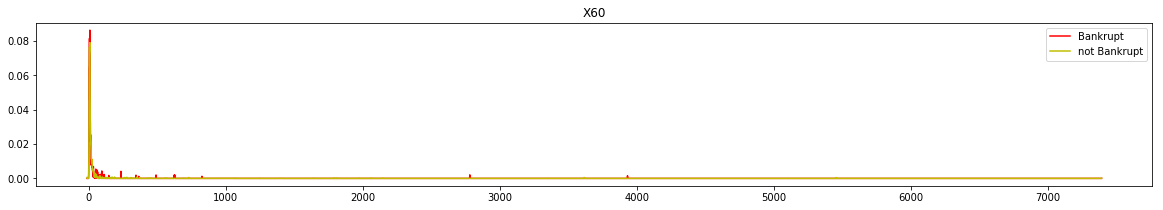

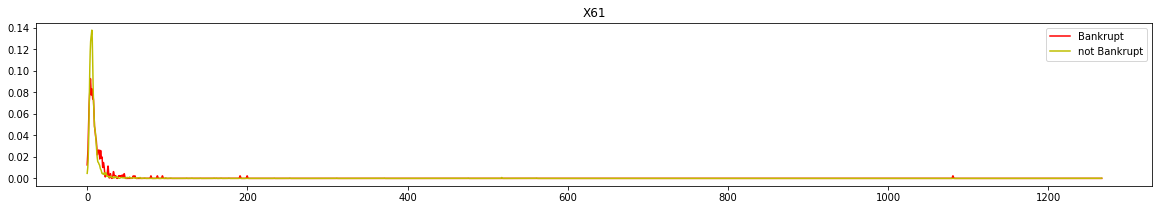

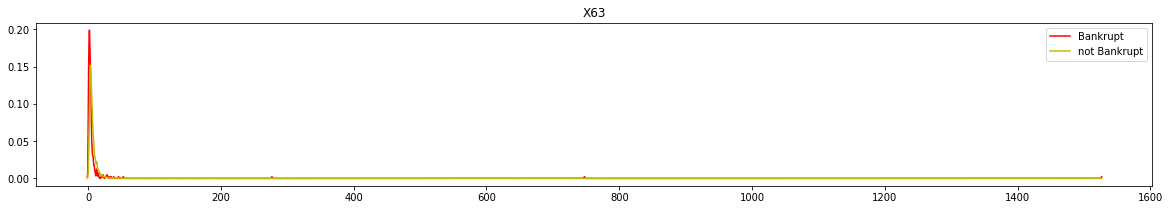

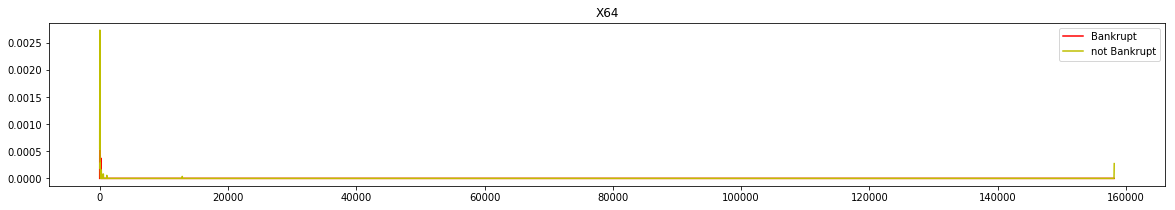

In [23]:
for i in train.columns[:-1]: 
    kde_plot(train, i)

**Define A Performance Function for All Models**

In [24]:
# A function to measure performance, inspired by TA's recitation
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix, auc, roc_curve

def performance(modelName,pred,true):
    confusion = confusion_matrix(pred, true)
    accuracy = accuracy_score(pred, true, normalize=True)
    recall = recall_score(pred, true)
    precision = precision_score(pred, true)
    fpr, tpr, thresholds = roc_curve(true, pred)
    auc_value= auc(fpr,tpr)
    print('{m:s} \n Confusion Matrix: \n {f} \n Accuracy: {a:.2%} \n Precision: {b:.2%} \n Recall: {c:.2%} \n AUC: {e:3.4f}'.format(
    a = accuracy, b = precision, c = recall, e = auc_value, f = confusion, m = modelName))

# Model Selection

Preparation

In [25]:
from sklearn.base import BaseEstimator, TransformerMixin
# A class to select numerical or categorical columns
# since Scikit-Learn doesn't handle DataFrames yet
# This function is from Lecture Notes
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

In [26]:
num_features = list(train_norm.columns)[:-1]

num_pipeline = Pipeline([
            ("select_numeric", DataFrameSelector( num_features )),
             ("imputer", SimpleImputer(strategy="median")),
         ])
X_train = num_pipeline.fit_transform(train_norm)

X_test = num_pipeline.fit_transform(test_norm)
# get true y
y_train = train_norm["Bankrupt"]
y_test = test_norm['Bankrupt']

# Baseline  Models

In [27]:
from sklearn.dummy import DummyClassifier

strats = { "stratified": {}, 
          "uniform": {},
          "most_frequent": {},
          "constant": {"constant": True}
         }
    
plt_num = 1

# Compute Accuracy for various baseline classifiers
for strat, args in strats.items():
    dmy_clf = DummyClassifier(strategy=strat, **args)
    acc_scores_dmy = cross_val_score(dmy_clf, X_train, y_train, cv=5, scoring="accuracy")
    
    print("{s}: Accuracy = {a:.2f}".format(s=strat, a=acc_scores_dmy.mean()))

stratified: Accuracy = 0.81
uniform: Accuracy = 0.50
most_frequent: Accuracy = 0.90
constant: Accuracy = 0.10


In [28]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()

# Train classifier
gnb.fit(
    X_train,
    y_train
)
# for calculating accuracy
y_pred = gnb.predict(X_test)
model = "Naive Bayes"
performance(model, y_pred,y_test)

Naive Bayes 
 Confusion Matrix: 
 [[155   9]
 [586  66]] 
 Accuracy: 27.08% 
 Precision: 88.00% 
 Recall: 10.12% 
 AUC: 0.5446


In [29]:
logistic_clf = linear_model.LogisticRegression(solver='liblinear')

from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)

from sklearn.svm import SVC
svm_clf = SVC(gamma="auto")

In [30]:
for name, clf in { "Logistic": logistic_clf,
                   "\n SVM": svm_clf,
                   "\n Random Forest": forest_clf
                 }.items():
    
    _= clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)

    scores = cross_val_score(clf, X_train, y_train, cv=10)
    performance(name, y_pred,y_test)
    print("avg cross val score={s:3.2f}".format(m=name, s=scores.mean()) )

Logistic 
 Confusion Matrix: 
 [[736  65]
 [  5  10]] 
 Accuracy: 91.42% 
 Precision: 13.33% 
 Recall: 66.67% 
 AUC: 0.5633
avg cross val score=0.90

 SVM 
 Confusion Matrix: 
 [[741  74]
 [  0   1]] 
 Accuracy: 90.93% 
 Precision: 1.33% 
 Recall: 100.00% 
 AUC: 0.5067
avg cross val score=0.90

 Random Forest 
 Confusion Matrix: 
 [[734  41]
 [  7  34]] 
 Accuracy: 94.12% 
 Precision: 45.33% 
 Recall: 82.93% 
 AUC: 0.7219
avg cross val score=0.92


Random Forest Model has the highest AUC, area under the ROC curve, which is the best. 

Since our data set is imbalanced, Random Forest should have good performance because Decision Trees are not sensitive to imbalance.

The Accuracy is also best for Random Forest. Recall is relatively high which is good for brankrupt prediction.

SVM has 100% recall, but the precision is very low as near 1% and AUC is lower than Naive Bayes. High Recall is good because we have no false negative, which means we capture every bankrupt companies at the cost of classifying many survival companies as bankrupt.

# Extra credit opportunities
- Address the issue of: classes being imbalanced
- Address the issue of: Different importance of each type of misclassification
    - It is 5 times worse to misclassify a company that *does go bankrupt* than to misclassify a company that does not go bankrupt
        - Suppose we invest in a company for which we predict it will not go bankrupt
            - We incur substantial losses for a bad investment
        - The loss from not investing in a company that we incorrectly classify as going bankrupt is small (opportunity cost)

# Improvement
Addressing imbalanced data for logistic regression by adjusting class weight parameter.

In [31]:
logistic_clf = linear_model.LogisticRegression(solver='liblinear', class_weight = 'balanced')

In [32]:
# Transform and fit the model
X_train = num_pipeline.fit_transform(train_norm)
_= logistic_clf.fit(X_train, y_train)
    
# Transform the test data
X_test = num_pipeline.fit_transform(test_norm)
y_pred = logistic_clf.predict(X_test)

scores = cross_val_score(logistic_clf, X_train, y_train, cv=10)
name = "Balanced Logistic Regression"
performance(name, y_pred,y_test)
print("avg cross val score={s:3.2f}".format(m=name, s=scores.mean()) )

Balanced Logistic Regression 
 Confusion Matrix: 
 [[595  24]
 [146  51]] 
 Accuracy: 79.17% 
 Precision: 68.00% 
 Recall: 25.89% 
 AUC: 0.7415
avg cross val score=0.78


After adding balanced class weight to logistic regression, AUC increases a lot but the accuracy decreases.

# Customize Loss Function with Gradient Boosting
- Using lightgbm package
- If y_true - y_pred > 0, which means true is 1 pred as 0, and this loss should be magnified
- Adding is_unbalance = True does not change the performance, probably because boosting made up by decision trees that are insensitive to imbalance

In [33]:
def custom_asymmetric_train(y_true, y_pred):
    residual = (y_true - y_pred).astype("float")
    grad = np.where(residual>0, -4.5*residual, -residual)
    hess = np.where(residual>0, 4.5, 1.0)
    return grad, hess

def custom_asymmetric_valid(y_true, y_pred):
    residual = (y_true - y_pred).astype("float")
    loss = np.where(residual > 0, (residual**2)*4.5, residual**2) 
    return "custom_asymmetric_eval", np.mean(loss), False

In [34]:
import lightgbm

# default lightgbm model with sklearn api
gbm = lightgbm.LGBMClassifier(is_unbalance=True) 

# updating objective function to custom
# also adding metrics to check different scores
gbm.set_params(**{'objective': custom_asymmetric_train}, metrics = ["mse", 'mae','auc'])

# fitting model 
gbm.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
    eval_metric=custom_asymmetric_valid,
    verbose=False,
)

y_pred = gbm.predict(X_test)

In [35]:
name = "Custom Loss Boosting"
performance(name, y_pred,y_test)

Custom Loss Boosting 
 Confusion Matrix: 
 [[728  28]
 [ 13  47]] 
 Accuracy: 94.98% 
 Precision: 62.67% 
 Recall: 78.33% 
 AUC: 0.8046


When the multiplier of residual in loss function is 4.5, AUC is the largest. It also represents around "5 times worse".

Accuracy is the best.

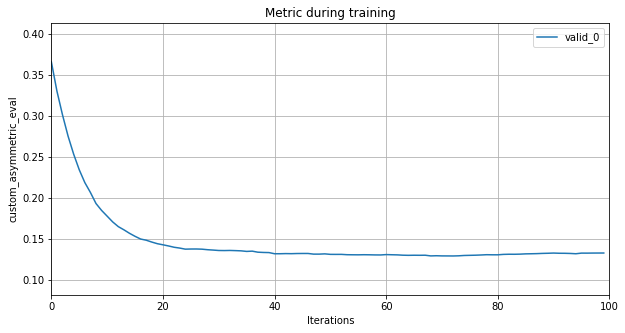

In [36]:
lightgbm.plot_metric(gbm, figsize=(10,5),metric='custom_asymmetric_eval')

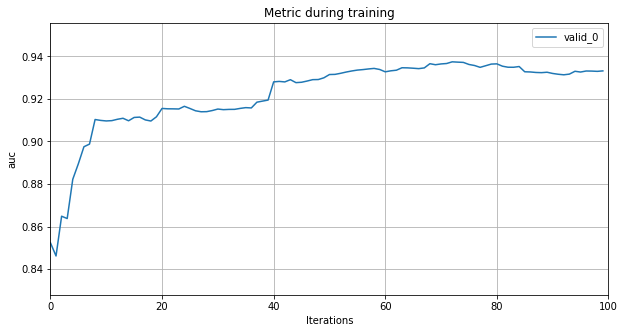

In [37]:
lightgbm.plot_metric(gbm, figsize=(10,5),metric='auc')

In [38]:
TEST_PATH = "./data/midterm_project"

import pandas as pd
import os

testFileName = os.path.join(TEST_PATH, "test.csv")

def MyModel(fileName, mean, std):
    print("Test file: ", fileName)
    # It should create an array of predictions; we initialize it to the empty array for convenience
    predictions = []
    
    data = pd.read_csv(fileName)
    
    cols = ['Id','X1','X2','X4','X6','X7','X10','X11','X14','X18','X22','X24','X25','X31',
        'X33','X35','X36','X37','X38','X42','X43','X46','X48','X49','X51','X54','X58','X62']
    test = data.drop(cols, axis=1)
    # convert to float
    for i in test : 
        test[i].replace("?",np.nan, inplace=True)
    test = test.astype(float)
    
    # scaling
    test_norm = (test - mean) / std
   
    X_test = num_pipeline.fit_transform(test_norm)
    
    y_pred = gbm.predict(X_test)
    predictions = list(y_pred)
    
    return predictions

predicts = MyModel(testFileName, mean, std)
print(predicts)

Test file:  ./data/midterm_project\test.csv
[0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1

In [39]:
print("Done")

Done
